## Company information

In [1]:
import pandas as pd

company_info = pd.read_csv("US/Filtered_Data/statics_filtered.csv")
company_info.head()

,Type,DSCD,BDATE,ENAME,EXMNEM,GEOGN,ISIN,ISINID,LOC,PCUR,TRAC,TYPE,WC05601,CURRENCY,Delisting Date
0,69568X,69568X,2010-06-29,TESLA,NAS,UNITED STATES,US88160R1014,P,U88160R101,U$,ORD,EQ,TSLA,U$,NaN
1,906150,906150,1973-01-02,GE AEROSPACE,NYS,UNITED STATES,US3696043013,P,U369604301,U$,ORD,EQ,GE,U$,NaN
2,905122,905122,1973-01-02,RTX,NYS,UNITED STATES,US75513E1010,P,U75513E101,U$,ORD,EQ,RTX,U$,NaN
3,904818,904818,1973-01-02,BOEING,NYS,UNITED STATES,US0970231058,P,U097023105,U$,ORD,EQ,BA,U$,NaN
4,154423,154423,1995-03-16,LOCKHEED MARTIN,NYS,UNITED STATES,US5398301094,P,U539830109,U$,ORD,EQ,LMT,U$,NaN


## Import return data

In [20]:
# import data
df = pd.read_feather("US/Filtered_Data/Financial_base_data_panel_filtered.feather")
df = df.sort_values(["Date", "Stock"])

## Examine value weighted and naive portfolios

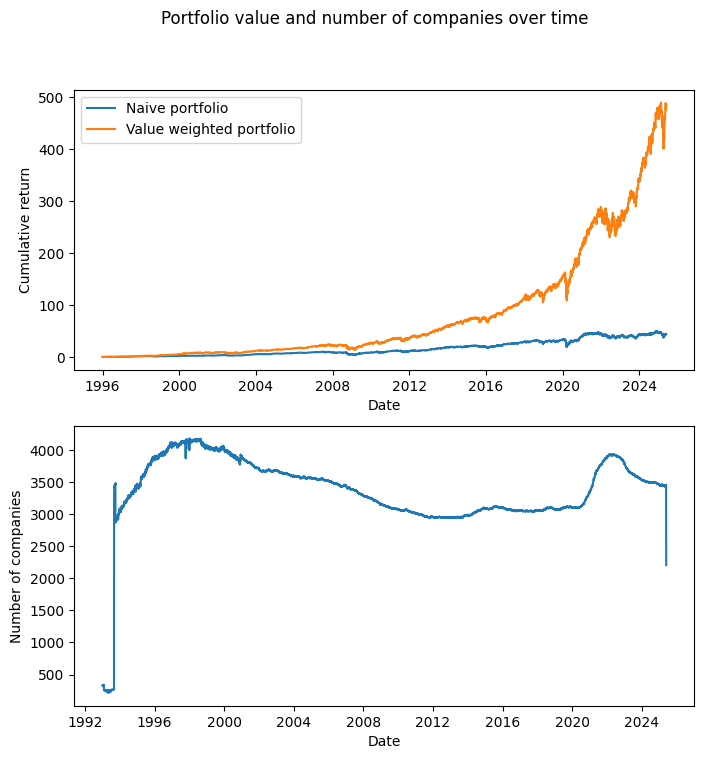

In [15]:
import matplotlib.pylab as plt

# Ensure your DataFrame is sorted by Date
df_mcap = df.loc[:, ["Date", "Stock", "MCAP", "Return"]]

# Step 1: Calculate total MCAP per Date
df_mcap['Total_MCAP'] = df_mcap.groupby('Date')['MCAP'].transform('sum')

# Step 2: Compute the weight for each stock
df_mcap['Weight'] = df_mcap['MCAP'] / df_mcap['Total_MCAP']

# Step 3: Compute weighted return per stock
df_mcap['Weighted_Return'] = df_mcap['Weight'] * df_mcap['Return']

# Step 4: Sum weighted returns per Date to get portfolio return
portfolio_returns = df_mcap.groupby('Date')['Weighted_Return'].sum()#.reset_index()
portfolio_returns = portfolio_returns.to_frame("MVW_PF_Return")
portfolio_returns["EW_PF_Return"] = df_mcap.groupby('Date')['Return'].mean()

cumulative_returns = portfolio_returns.add(1.).cumprod().subtract(1.)
unique_stocks_over_time = df.groupby("Date")["Stock"].nunique()


fig, axs = plt.subplots(2, 1, figsize = (8, 8))
axs[0].plot(cumulative_returns.loc["1996-01-01":]["EW_PF_Return"], label = "Naive portfolio")
axs[0].plot(cumulative_returns.loc["1996-01-01":]["MVW_PF_Return"], label = "Value weighted portfolio")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative return")
axs[0].legend()

axs[1].plot(unique_stocks_over_time)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Number of companies")

plt.suptitle("Portfolio value and number of companies over time")
plt.show()

del df_mcap

/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: divide by zero encountered in log
  logs = np.log(top_k) - np.log(x_k1)
/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: invalid value encountered in subtract
  logs = np.log(top_k) - np.log(x_k1)
/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: invalid value encountered in log
  logs = np.log(top_k) - np.log(x_k1)


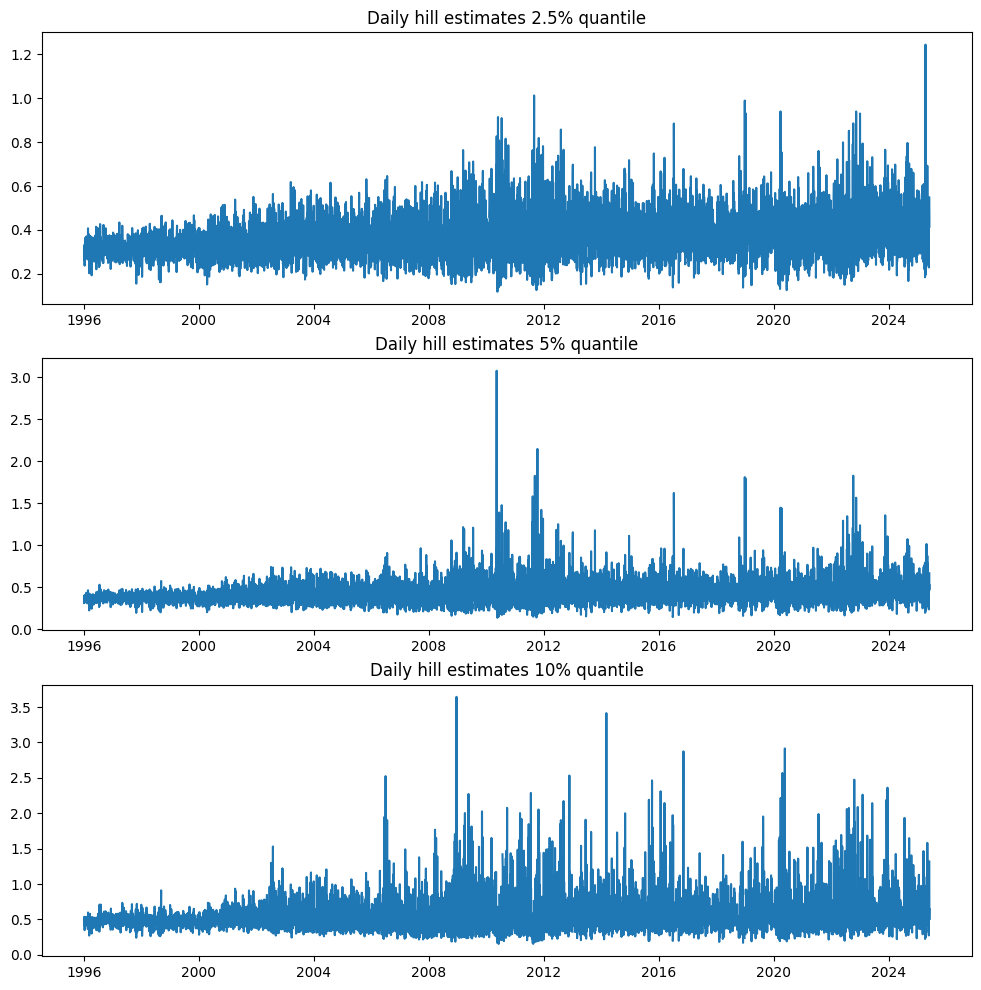

In [ ]:
import numpy as np
from typing import Union

def hill_estimator(data: Union[np.array, pd.Series], k_frequency: int, tail: str = "upper") -> float:
    
    if isinstance(data, pd.Series):
        data = data.values

    k = int(len(data) * k_frequency)
    if k <= 0 or k >= len(data):
        raise ValueError("k must be between 1 and len(data) - 1")

    if tail == "upper":
        sorted_data = np.sort(data)[::-1]
    elif tail == "lower":
        sorted_data = np.sort(-data)[::-1]
    else:
        raise ValueError("tail must be 'upper' or 'lower'")

    top_k = sorted_data[:k]
    x_k1 = sorted_data[k]

    try:
        logs = np.log(top_k) - np.log(x_k1)
        hill_est = np.mean(logs)
    except: 
        hill_est = np.nan
    return hill_est

start_date = "1996-01-01"

df_hill = df[df["Date"] > start_date].loc[:, ["Date", "Stock", "Return"]].copy()
dt, df_tmp = next(iter(df_hill.groupby("Date")))

hill_daily_025 = df_hill.groupby("Date")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.025, tail = "lower"))
hill_daily_05 = df_hill.groupby("Date")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.05, tail = "lower"))
hill_daily_10 = df_hill.groupby("Date")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.10, tail = "lower"))

fig, axs = plt.subplots(3, 1, figsize = (12, 12))
axs[0].plot(hill_daily_025)
axs[0].set_title("Daily hill estimates 2.5% quantile")
axs[1].plot(hill_daily_05)
axs[1].set_title("Daily hill estimates 5% quantile")
axs[2].plot(hill_daily_10)
axs[2].set_title("Daily hill estimates 10% quantile")
plt.show()

/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: divide by zero encountered in log
  logs = np.log(top_k) - np.log(x_k1)
/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: invalid value encountered in subtract
  logs = np.log(top_k) - np.log(x_k1)
/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: invalid value encountered in log
  logs = np.log(top_k) - np.log(x_k1)


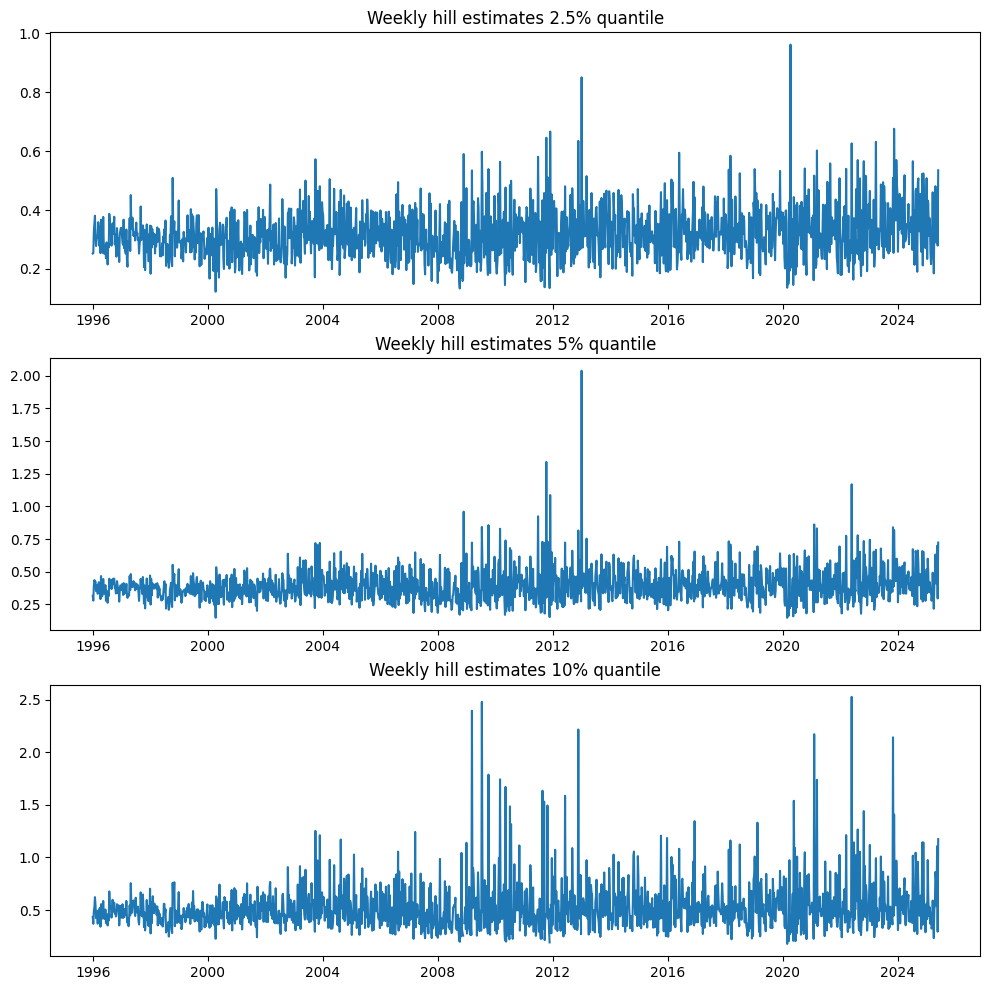

In [73]:
df_hill["Log_Return"] = df_hill["Return"].add(1.).apply(np.log)

# Create a 'Month' column (or just group using to_period)
df_hill['Week'] = df_hill['Date'].dt.to_period('W')

# Group by Month and Stock, sum the log returns
weekly_returns = (
    df_hill.groupby(['Stock', 'Week'])['Log_Return']
    .sum()
    .reset_index()
)
weekly_returns["Return"] = weekly_returns["Log_Return"].apply(np.exp).subtract(1.)

hill_monthly_025 = weekly_returns.groupby("Week")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.025, tail = "lower"))
hill_monthly_05 = weekly_returns.groupby("Week")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.05, tail = "lower"))
hill_monthly_10 = weekly_returns.groupby("Week")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.10, tail = "lower"))

fig, axs = plt.subplots(3, 1, figsize = (12, 12))
axs[0].plot(hill_monthly_025.index.to_timestamp(), hill_monthly_025.values)
axs[0].set_title("Weekly hill estimates 2.5% quantile")
axs[1].plot(hill_monthly_05.index.to_timestamp(), hill_monthly_05.values)
axs[1].set_title("Weekly hill estimates 5% quantile")
axs[2].plot(hill_monthly_10.index.to_timestamp(), hill_monthly_10.values)
axs[2].set_title("Weekly hill estimates 10% quantile")
plt.show()

/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: divide by zero encountered in log
  logs = np.log(top_k) - np.log(x_k1)
/tmp/ipykernel_362107/1370160120.py:24: RuntimeWarning: invalid value encountered in log
  logs = np.log(top_k) - np.log(x_k1)


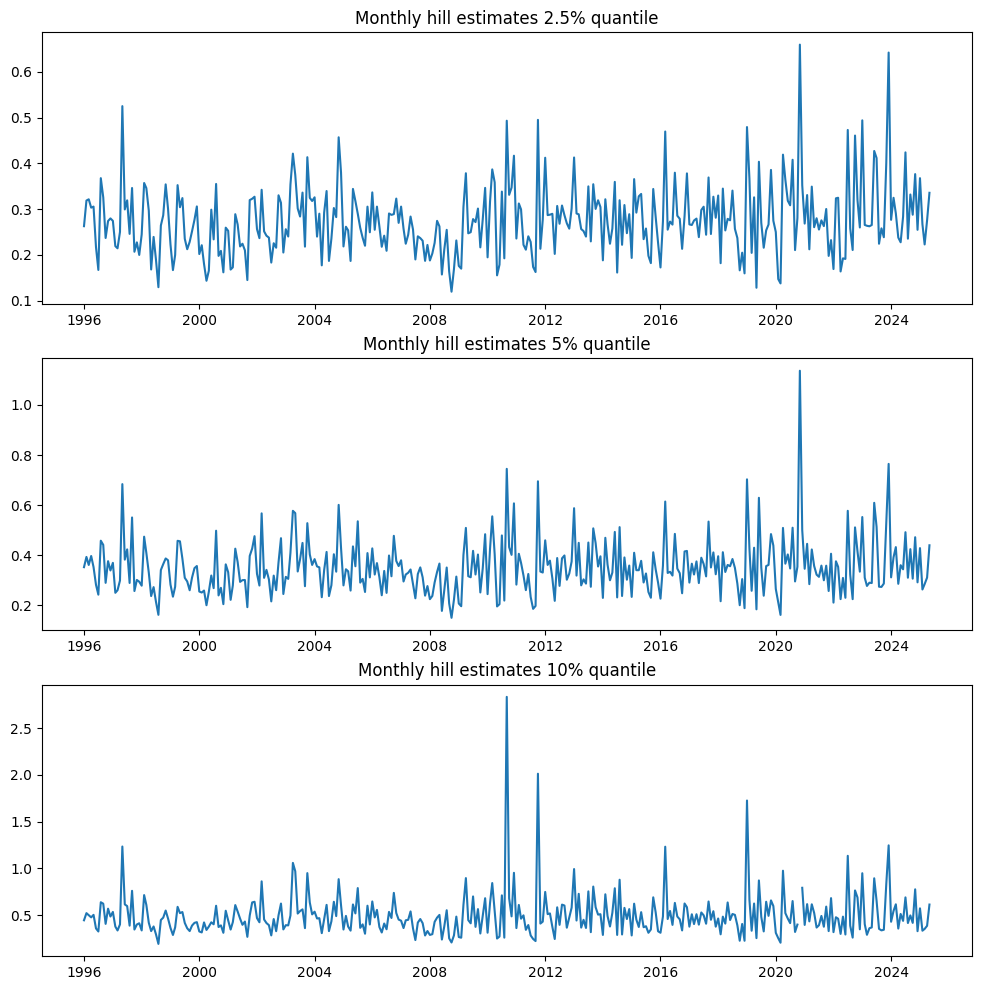

In [84]:
# Create a 'Month' column (or just group using to_period)
df_hill['Month'] = df_hill['Date'].dt.to_period('M')

# Group by Month and Stock, sum the log returns
monthly_returns = (
    df_hill.groupby(['Stock', 'Month'])['Log_Return']
    .sum()
    .reset_index()
)
monthly_returns["Return"] = monthly_returns["Log_Return"].apply(np.exp).subtract(1.)

hill_monthly_025 = monthly_returns.groupby("Month")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.025, tail = "lower"))
hill_monthly_05 = monthly_returns.groupby("Month")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.05, tail = "lower"))
hill_monthly_10 = monthly_returns.groupby("Month")["Return"].apply(lambda data: hill_estimator(data, k_frequency=0.10, tail = "lower"))

fig, axs = plt.subplots(3, 1, figsize = (12, 12))
axs[0].plot(hill_monthly_025.index.to_timestamp(), hill_monthly_025.values)
axs[0].set_title("Monthly hill estimates 2.5% quantile")
axs[1].plot(hill_monthly_05.index.to_timestamp(), hill_monthly_05.values)
axs[1].set_title("Monthly hill estimates 5% quantile")
axs[2].plot(hill_monthly_10.index.to_timestamp(), hill_monthly_10.values)
axs[2].set_title("Monthly hill estimates 10% quantile")
plt.show()